<a href="https://colab.research.google.com/github/deetip/DarkMatter/blob/main/GravitationalWave/GravitationalWave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=99252 sha256=b9940cd7f61a62806044ed35fe667a9921a13e2eb8436333db6b82deac2458a6
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba57f92ad0d5619f083df43cf319a151c4e06
Successfully built ligo-segments


The following example is from: https://gwpy.github.io/docs/stable/examples/signal/gw150914/

In [3]:
# # -- Set a GPS time:
t0 = 1126259462.4   #time to the 0.1 sec # -- GW150914- first neutron star merger. Use the 'GPS' as t0 in own code. Chose smth with high SNR
# t0 = 1187008882.4    # -- GW170817

from gwpy.timeseries import TimeSeries #
hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478) #line fetches day in 32 day period and stores in 'hdata'. 32 days bc not too big or small

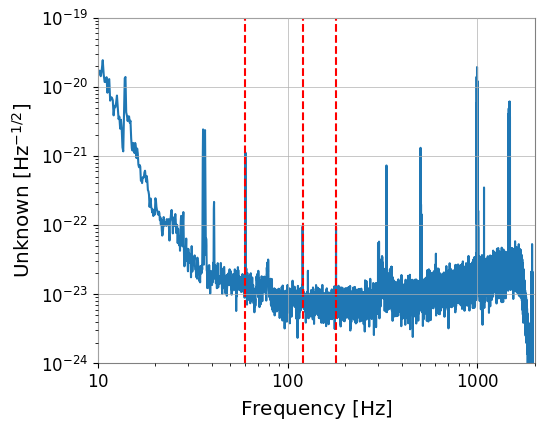

In [5]:
import matplotlib.pyplot as plt

# -- Plot ASD
fig2 = hdata.asd(fftlength=8).plot()
plt.xlim(10,2000)
ymin = 1e-24
ymax = 1e-19
plt.ylim(ymin, ymax)
plt.vlines(60, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(120, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(180, ymin, ymax, linestyle="dashed", color="red")
#'blue' shows where the most power at. 60,120,180 are unwanted frequencies bc they represent the ac current

In [7]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate)#search for grav wave signal, 100 Hz, 50-250 is the section we want to study for GW

notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)] #freqquency you want to remove

zpk = filter_design.concatenate_zpks(bp, *notches)

hfilt = hdata.filter(zpk, filtfilt=True)


In [10]:
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))
# crop out unwanted frequency and only show what we want

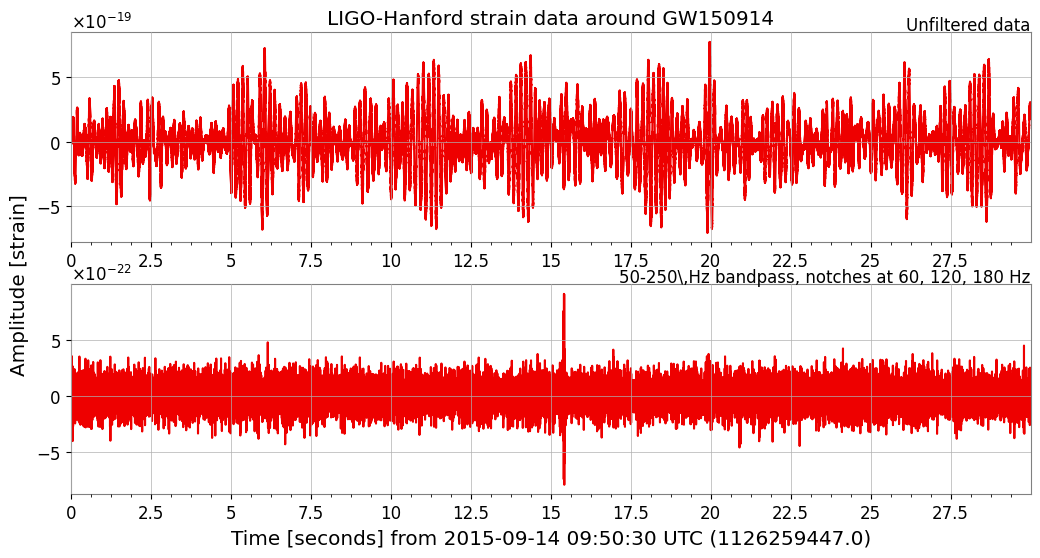

In [9]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()
#top data is without filter, bottom has filters. Bottom shows clear peak which is the chirp

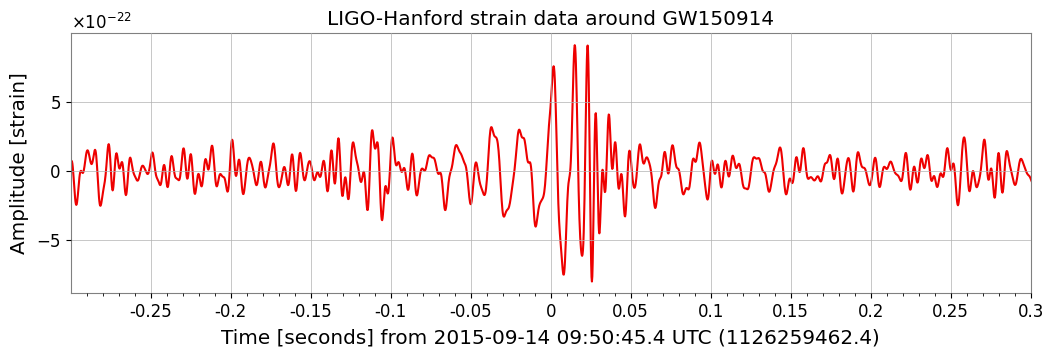

In [12]:
import matplotlib.pyplot as plt

plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(t0 - 0.3, t0 + .3)
ax.set_xscale('seconds', epoch=t0)
plot.show()
#zooms in to the peak
x_val = plt.gca().lines[0].get_xdata()
y_val = plt.gca().lines[0].get_ydata()


In [13]:
ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)
lfilt = ldata.filter(zpk, filtfilt=True)
#do same process for livingston data

In [14]:
lfilt.shift('6.9ms')
lfilt *= -1
#gravitational wave takes time, taking into consideration of time delay

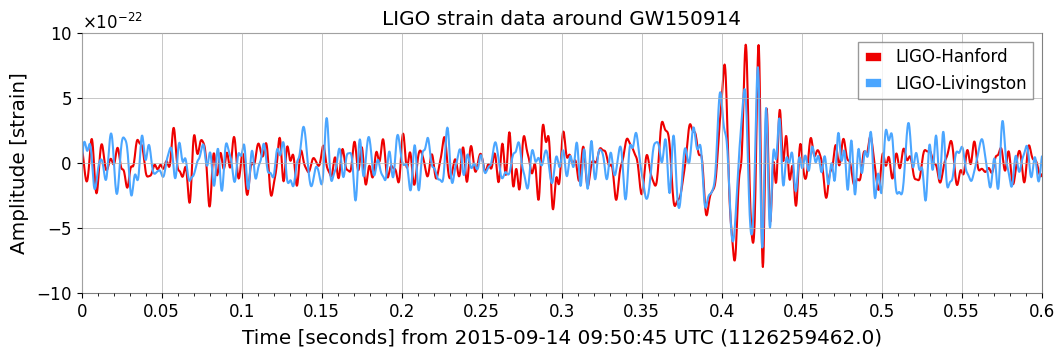

In [15]:
plot = Plot(figsize=[12, 4])
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW150914')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()
#shows the data for both stations to see if they math

https://colab.research.google.com/github/losc-tutorial/quickview/blob/master/index.ipynb
Also from: https://gwpy.github.io/docs/stable/examples/signal/qscan/

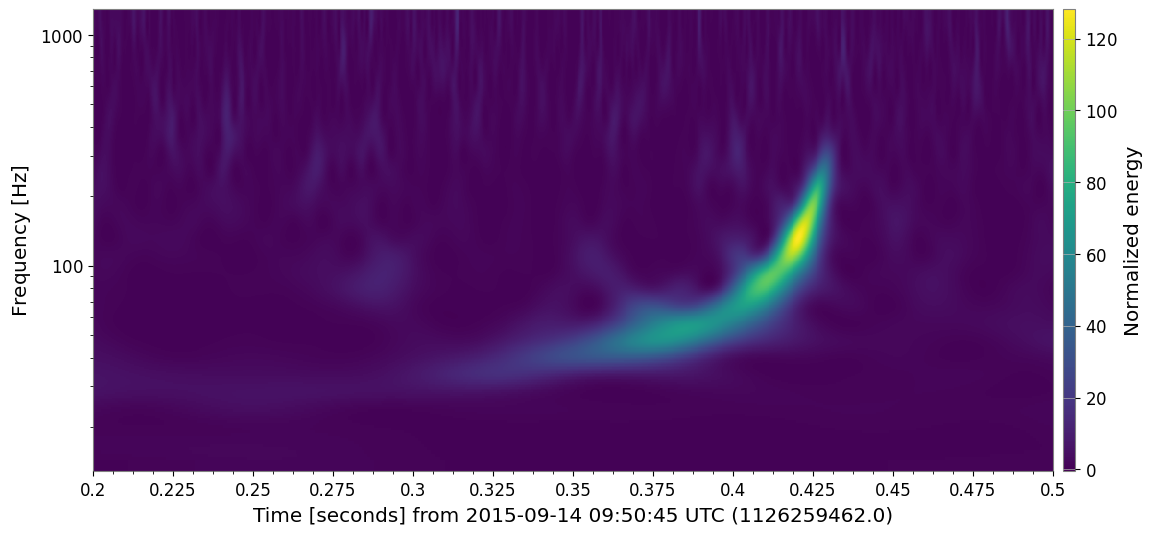

In [16]:
dt = 0.2  #-- Set width of q-transform plot, in seconds
hq = hfilt.q_transform(outseg=(t0-dt, t0+0.1))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalized energy")
ax.grid(False)
ax.set_yscale('log')

In [17]:
from scipy.io.wavfile import write
import numpy as np
#to create sound wave

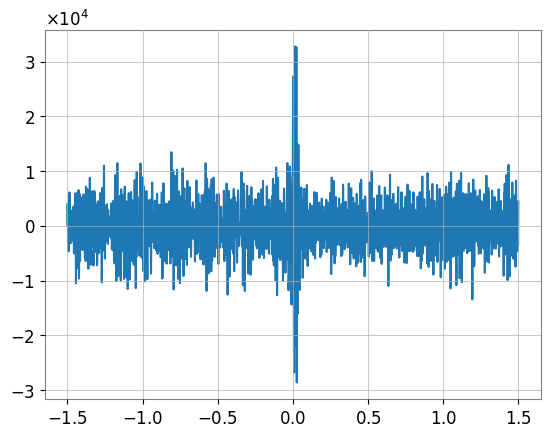

In [18]:
amplitude = np.iinfo(np.int16).max

ind = np.where((x_val < (t0+1.5)) & (x_val > (t0-1.5)))
y = y_val[ind]
# y = y**3
y = y / np.max(y)
plt.plot(x_val[ind] - t0, (np.array(y) * amplitude).astype(np.int16))

In [22]:
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))#sample rate
print("fs = ", fs)
write("example.wav", fs, (np.array(y) * amplitude).astype(np.int16))

fs =  4096


In [20]:
from google.colab import files
files.download("example.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Make C

(0.0, 0.1)

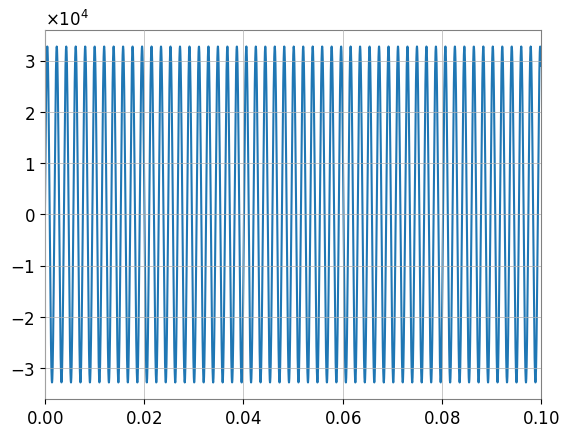

In [21]:
samplerate = 44100; fs = 261.63 * 2.0 #frequency of C
t = np.linspace(0., 1., samplerate) #plays for 1 sec
amplitude = np.iinfo(np.int16).max #gives max amp
data = amplitude * np.sin(2. * np.pi * fs * t) #give wave
plt.plot(t, data)
plt.xlim(0, 0.1)

In [24]:
write("C.wav", samplerate, data.astype(np.int16))
files.download("C.wav")#sound of black hoels merging

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>